In [ ]:
from transformers import Blip2Processor, Blip2ForConditionalGeneration
import torch
from PIL import Image

# Load BLIP-2 model and processor
processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device: " + device)
model.to(device)


2025-03-23 11:41:18.429887: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-23 11:41:18.436655: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742701278.444761   17517 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742701278.447201   17517 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742701278.453450   17517 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/jalil/dev/unitree-vlm/env/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Blip2ForConditionalGeneration(
  (vision_model): Blip2VisionModel(
    (embeddings): Blip2VisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): Blip2Encoder(
      (layers): ModuleList(
        (0-38): 39 x Blip2EncoderLayer(
          (self_attn): Blip2Attention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1408, out_features=4224, bias=True)
            (projection): Linear(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): Blip2MLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((

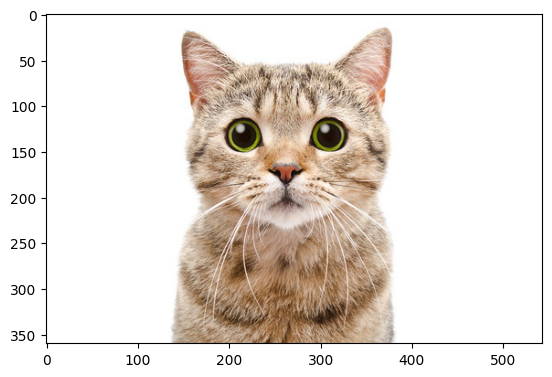

In [2]:
import cv2
from matplotlib import pyplot as plt

img2 = cv2.imread('cat.jpg')
image_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB) 
plt.imshow(image_rgb)

In [3]:
from PIL import Image

prompt = "Describe what you are seeing. Answer:"

img = Image.fromarray(image_rgb)

# Process the image and generate description
inputs = processor(img, text=prompt, return_tensors="pt").to(device, torch.float16)
with torch.no_grad():
    output = model.generate(**inputs)

caption = processor.batch_decode(output, skip_special_tokens=True)[0]
print("BLIP-2 Caption:", caption)



BLIP-2 Caption: Describe what you are seeing. Answer: a cat



In [2]:
import cv2
import time

def access_camera(camera_id=0, fps=7):
    """
    Access the camera at a specified frame rate.
    
    Args:
        camera_id (int): Camera device ID (default: 0 for primary camera)
        fps (int): Target frames per second (default: 7)
    """
    # Calculate the delay between frames to achieve target FPS
    frame_delay = 1.0 / fps
    
    # Open the camera
    cap = cv2.VideoCapture(camera_id)
    
    # Check if camera opened successfully
    if not cap.isOpened():
        print("Error: Could not open camera.")
        return
    
    print(f"Camera opened successfully. Target FPS: {fps}")
    
    try:
        while True:
            # Record the start time of this frame
            start_time = time.time()
            
            # Capture frame-by-frame
            ret, frame = cap.read()
            
            # Check if frame was captured successfully
            if not ret:
                print("Error: Failed to capture frame.")
                break
            
            # Display the resulting frame
            cv2.imshow('Camera Feed (7 FPS)', frame)
            
            # Press 'q' to exit
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
            
            # Calculate how long to wait to maintain target FPS
            processing_time = time.time() - start_time
            wait_time = max(0, frame_delay - processing_time)
            time.sleep(wait_time)
            
            # Optional: print actual FPS
            actual_fps = 1.0 / (time.time() - start_time)
            # Uncomment to see actual FPS:
            # print(f"Actual FPS: {actual_fps:.2f}")
            
    finally:
        # Release the camera and close windows
        cap.release()
        cv2.destroyAllWindows()


if __name__ == "__main__":
    # Run with default settings (camera ID 0, 7 FPS)
    access_camera()
    
    # Or specify camera ID and FPS
    # access_camera(camera_id=1, fps=7)

Camera opened successfully. Target FPS: 7


KeyboardInterrupt: 

In [2]:
import cv2
import time
import torch
from PIL import Image
import numpy as np

def access_camera_with_captioning(camera_id=0, fps=7):
    """
    Access the camera at a specified frame rate and generate captions for each frame using BLIP-2.
    
    Args:
        camera_id (int): Camera device ID (default: 0 for primary camera)
        fps (int): Target frames per second (default: 7)
    """
    # Check if CUDA is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load BLIP-2 model and processor
    try:
        from transformers import Blip2Processor, Blip2ForConditionalGeneration
        
        processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
        model = Blip2ForConditionalGeneration.from_pretrained(
            "Salesforce/blip2-opt-2.7b", 
            torch_dtype=torch.float16
        ).to(device)
        print("BLIP-2 model loaded successfully")
    except ImportError:
        print("Error: Please install the transformers library:")
        print("pip install transformers")
        return
    
    # Calculate the delay between frames to achieve target FPS
    frame_delay = 1.0 / fps
    
    # Open the camera
    cap = cv2.VideoCapture(camera_id)
    
    # Check if camera opened successfully
    if not cap.isOpened():
        print("Error: Could not open camera.")
        return
    
    print(f"Camera opened successfully. Target FPS: {fps}")
    
    # Set up the prompt for image captioning
    prompt = "Describe what you are seeing. Answer:"
    
    try:
        while True:
            # Record the start time of this frame
            start_time = time.time()
            
            # Capture frame-by-frame
            ret, frame = cap.read()
            
            # Check if frame was captured successfully
            if not ret:
                print("Error: Failed to capture frame.")
                break
            
            # Convert the frame from BGR (OpenCV format) to RGB (PIL format)
            image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # Convert to PIL Image for BLIP-2 processing
            img = Image.fromarray(image_rgb)
            
            # Process the image and generate description
            inputs = processor(img, text=prompt, return_tensors="pt").to(device, torch.float16)
            with torch.no_grad():
                output = model.generate(**inputs)
            
            caption = processor.batch_decode(output, skip_special_tokens=True)[0]
            print("BLIP-2 Caption:", caption)
            
            # Display the resulting frame
            # Add caption to the frame
            cv2.putText(frame, "Caption: " + caption[:50], (10, 30), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
            if len(caption) > 50:
                cv2.putText(frame, caption[50:100], (10, 60), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
            
            cv2.imshow('Camera Feed with BLIP-2 Captioning', frame)
            
            # Press 'q' to exit
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
            
            # Calculate how long to wait to maintain target FPS
            processing_time = time.time() - start_time
            wait_time = max(0, frame_delay - processing_time)
            
            # Print actual FPS (will likely be lower due to BLIP-2 processing)
            actual_fps = 1.0 / (processing_time + wait_time if wait_time > 0 else processing_time)
            print(f"Actual FPS: {actual_fps:.2f}")
            
            if wait_time > 0:
                time.sleep(wait_time)
            
    finally:
        # Release the camera and close windows
        cap.release()
        cv2.destroyAllWindows()


if __name__ == "__main__":
    # Run the camera with captioning
    access_camera_with_captioning()

Using device: cpu


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

BLIP-2 model loaded successfully
Camera opened successfully. Target FPS: 7
BLIP-2 Caption: Describe what you are seeing. Answer: a man with a moustache

Actual FPS: 0.11


KeyboardInterrupt: 

In [8]:
import cv2
import time
import torch
from PIL import Image
import numpy as np
import argparse
from datetime import datetime
import os
import threading
import queue
import sounddevice as sd
import soundfile as sf
from scipy.io.wavfile import write as write_wav
import speech_recognition as sr
from gtts import gTTS
import pygame
from transformers import Blip2Processor, Blip2ForConditionalGeneration

class ConversationalVisualAssistant:
    def __init__(self, camera_id=0, fps=5, save_output=False, output_dir="output"):
        """
        Initialize the conversational visual assistant.
        
        Args:
            camera_id (int): Camera device ID
            fps (int): Target frames per second for video processing
            save_output (bool): Whether to save output files
            output_dir (str): Directory to save output files
        """
        # Basic settings
        self.camera_id = camera_id
        self.fps = fps
        self.save_output = save_output
        self.output_dir = output_dir
        self.frame_delay = 1.0 / fps
        self.running = False
        self.speaking = False
        self.listening = False
        
        # Create output directory if needed
        if save_output and not os.path.exists(output_dir):
            os.makedirs(output_dir)
            print(f"Created output directory: {output_dir}")
        
        # Set up communication queues
        self.command_queue = queue.Queue()  # Commands from speech recognition
        self.response_queue = queue.Queue()  # Responses to be spoken
        self.current_frame = None  # Store the current camera frame
        
        # Check if CUDA is available
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        
        # Initialize pygame for audio playback
        pygame.mixer.init()
        
        # Load models
        self.load_models()
        
    def load_models(self):
        """Load the required models for vision and speech processing."""
        print("Loading models...")
        
        # Load BLIP-2 model
        try:
            self.processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
            self.model = Blip2ForConditionalGeneration.from_pretrained(
                "Salesforce/blip2-opt-2.7b", 
                torch_dtype=torch.float16
            ).to(self.device)
            print("BLIP-2 model loaded successfully")
        except Exception as e:
            print(f"Error loading BLIP-2 model: {e}")
            raise
            
        # Load YOLO model for object detection if available
        try:
            self.yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True).to(self.device)
            self.has_yolo = True
            print("YOLO model loaded successfully")
        except Exception as e:
            print(f"YOLO model loading failed: {e}")
            print("Object detection will be disabled")
            self.has_yolo = False
            
        # Initialize speech recognizer
        self.recognizer = sr.Recognizer()
        print("Speech recognition initialized")
        
        print("All models loaded successfully")
    
    def start(self):
        """Start all processing threads and begin the assistant."""
        self.running = True
        
        # Start the camera thread
        self.camera_thread = threading.Thread(target=self.camera_processing_loop)
        self.camera_thread.daemon = True
        self.camera_thread.start()
        
        # Start the speech recognition thread
        self.speech_thread = threading.Thread(target=self.speech_recognition_loop)
        self.speech_thread.daemon = True
        self.speech_thread.start()
        
        # Start the command processing thread
        self.command_thread = threading.Thread(target=self.command_processing_loop)
        self.command_thread.daemon = True
        self.command_thread.start()
        
        # Start the text-to-speech thread
        self.tts_thread = threading.Thread(target=self.text_to_speech_loop)
        self.tts_thread.daemon = True
        self.tts_thread.start()
        
        print("All threads started. Assistant is running.")
        print("Speak to the assistant. Say 'describe' to ask for a description of what's visible.")
        
        # Wait for a quit command
        try:
            while self.running:
                key = cv2.waitKey(1) & 0xFF
                if key == ord('q'):
                    self.running = False
                time.sleep(0.1)
        except KeyboardInterrupt:
            self.running = False
        
        # Clean up
        cv2.destroyAllWindows()
        print("Assistant stopped.")
    
    def camera_processing_loop(self):
        """Main loop for camera processing."""
        # Open the camera
        cap = cv2.VideoCapture(self.camera_id)
        
        # Check if camera opened successfully
        if not cap.isOpened():
            print("Error: Could not open camera.")
            self.running = False
            return
        
        print(f"Camera opened successfully. Target FPS: {self.fps}")
        
        try:
            while self.running:
                # Capture frame
                ret, frame = cap.read()
                
                if not ret:
                    print("Error: Failed to capture frame.")
                    break
                
                # Store the current frame for processing
                self.current_frame = frame.copy()
                
                # Display status on frame
                status_frame = frame.copy()
                
                # Add status indicators
                cv2.putText(status_frame, f"Listening: {'Yes' if self.listening else 'No'}", 
                            (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0) if self.listening else (0, 0, 255), 2)
                cv2.putText(status_frame, f"Speaking: {'Yes' if self.speaking else 'No'}", 
                            (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0) if self.speaking else (0, 0, 255), 2)
                
                # Display help text
                cv2.putText(status_frame, "Say 'describe' to analyze the scene", 
                            (10, status_frame.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
                
                # Display the frame
                cv2.imshow('Conversational Visual Assistant', status_frame)
                
                # Control frame rate
                time.sleep(self.frame_delay)
                
        finally:
            cap.release()
    
    def process_frame(self, frame):
        """
        Process a single frame and generate a description.
        
        Args:
            frame: The image frame to process
            
        Returns:
            str: Caption describing the frame
        """
        # Convert the frame from BGR to RGB
        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Convert to PIL Image for BLIP-2 processing
        img = Image.fromarray(image_rgb)
        
        # Process the image with YOLO if available
        objects_detected = []
        if self.has_yolo:
            # Get detections
            results = self.yolo_model(image_rgb)
            detections = results.pandas().xyxy[0]
            
            # Get object names with confidence > 0.5
            confident_detections = detections[detections['confidence'] >= 0.5]
            objects_detected = confident_detections['name'].tolist()
        
        # Create a prompt based on detected objects
        if objects_detected:
            detected_str = ", ".join(set(objects_detected))
            prompt = f"I can see {detected_str}. Please describe this scene in detail for a visually impaired person."
        else:
            prompt = "Please describe what you see in this image in detail for a visually impaired person."
        
        # Process the image and generate description
        inputs = self.processor(img, text=prompt, return_tensors="pt").to(self.device, torch.float16)
        with torch.no_grad():
            output = self.model.generate(**inputs, max_length=100)
        
        # Decode the caption
        caption = self.processor.batch_decode(output, skip_special_tokens=True)[0]
        return caption
    
    def speech_recognition_loop(self):
        """Listen for voice commands continuously."""
        print("Speech recognition started. Listening for commands...")
        
        with sr.Microphone() as source:
            # Adjust for ambient noise
            self.recognizer.adjust_for_ambient_noise(source)
            
            while self.running:
                if self.speaking:
                    # Don't listen while speaking to avoid feedback
                    time.sleep(0.5)
                    continue
                    
                try:
                    self.listening = True
                    print("Listening...")
                    audio = self.recognizer.listen(source, timeout=3, phrase_time_limit=5)
                    self.listening = False
                    
                    try:
                        text = self.recognizer.recognize_google(audio).lower()
                        print(f"Recognized: {text}")
                        
                        # Add to command queue
                        self.command_queue.put(text)
                    except sr.UnknownValueError:
                        # Speech wasn't understood
                        pass
                    except sr.RequestError as e:
                        print(f"Speech recognition service error: {e}")
                except Exception as e:
                    self.listening = False
                    print(f"Listening error: {e}")
                    time.sleep(1)
    
    def command_processing_loop(self):
        """Process voice commands from the queue."""
        while self.running:
            try:
                # Get a command from the queue
                command = self.command_queue.get(timeout=1)
                
                if "describe" in command or "what do you see" in command or "tell me what you see" in command:
                    print("Processing 'describe' command...")
                    
                    # Get the current frame
                    if self.current_frame is not None:
                        # Speak a prompt
                        self.response_queue.put("Let me look at what's in front of me.")
                        
                        # Process the frame
                        caption = self.process_frame(self.current_frame)
                        
                        # Add to response queue
                        self.response_queue.put(caption)
                    else:
                        self.response_queue.put("I can't see anything right now.")
                
                elif "exit" in command or "quit" in command or "stop" in command:
                    self.response_queue.put("Stopping the assistant.")
                    time.sleep(3)  # Wait for speech to complete
                    self.running = False
                
                elif "hello" in command or "hi" in command:
                    self.response_queue.put("Hello! I'm your visual assistant. Ask me to describe what I see.")
                
                else:
                    self.response_queue.put("I heard you say " + command + ". You can ask me to describe what I see.")
                
                # Mark command as processed
                self.command_queue.task_done()
                
            except queue.Empty:
                pass
            except Exception as e:
                print(f"Command processing error: {e}")
    
    def text_to_speech_loop(self):
        """Convert text responses to speech."""
        while self.running:
            try:
                # Get a response from the queue
                response = self.response_queue.get(timeout=1)
                
                if response:
                    print(f"Speaking: {response}")
                    self.speaking = True
                    
                    # Generate speech
                    tts = gTTS(text=response, lang='en')
                    temp_file = "temp_speech.mp3"
                    tts.save(temp_file)
                    
                    # Play the speech
                    pygame.mixer.music.load(temp_file)
                    pygame.mixer.music.play()
                    while pygame.mixer.music.get_busy():
                        time.sleep(0.1)
                    
                    # Remove temporary file
                    try:
                        os.remove(temp_file)
                    except:
                        pass
                    
                    self.speaking = False
                
                # Mark response as processed
                self.response_queue.task_done()
                
            except queue.Empty:
                pass
            except Exception as e:
                self.speaking = False
                print(f"Text-to-speech error: {e}")

def main():
    parser = argparse.ArgumentParser(description="Conversational Visual Assistant")
    parser.add_argument("--camera", type=int, default=0, help="Camera device ID (default: 0)")
    parser.add_argument("--fps", type=int, default=5, help="Target frames per second (default: 5)")
    parser.add_argument("--save", action="store_true", help="Save output files")
    parser.add_argument("--output", type=str, default="output", help="Output directory (default: 'output')")
    args = parser.parse_args()
    
    # Create and start the assistant
    assistant = ConversationalVisualAssistant(
        camera_id=args.camera,
        fps=args.fps,
        save_output=args.save,
        output_dir=args.output
    )
    
    assistant.start()

if __name__ == "__main__":
    main()

pygame 2.6.1 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


usage: ipykernel_launcher.py [-h] [--camera CAMERA] [--fps FPS] [--save]
                             [--output OUTPUT]
ipykernel_launcher.py: error: argument --fps: invalid int value: '/run/user/1000/jupyter/runtime/kernel-v3a8b005cffb756806d0d5b107fb848f9b3c7c5e14.json'


SystemExit: 2

/home/jalil/dev/unitree-vlm/env/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3557: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
%tb